In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import BasicFunctions as SGf
from Models.spectragen import genspectra as gspec
import random
from scipy.ndimage import gaussian_filter
from Models.spectrapad import padspectra as PS
import Models.water.waterU as MW
import matplotlib.cm as cm
from scipy.signal import savgol_filter

In [2]:
# define wavelength range
wavelength = np.arange(400,2500,1)

# Generate soil spectra

(1, 2100)


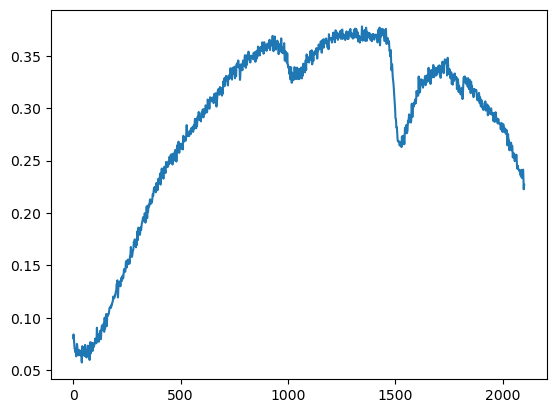

In [14]:
prop_test_1 = []
# set soil properties (-1 means not available)
spectrabrand = 'FOSS'  # ASD, FOSS, Spectral Evolution, or None
Clay = 8   # %
Silt = 7   # %   
# Sand content is calculated by 100 - Clay - Silt
SOM = 120  # soil organic matter, g/kg
Nitrogen = 2.2  # total nitrogen content, g/kg
CEC = 123 # cation exchange capacity, cmol(+)/kg
OC = 38 # organic carbon content, g/kg
tP = -1 # total phosphorus content, mg/kg
pH_w = 4.7 # pH measured from water solution
Fe = 80000 # iron content, mg/kg
dens = -1 # soil bulk density, g/cm3
ec = -1 # electrical conductivity, mS/m
caco3 = -1 # CaCO3 content, g/kg
tc = -1 # total carbon content, %

prop_test_1.append(SGf.setProp(spectrabrand, Clay, Silt, SOM, Nitrogen, CEC, OC, tP, pH_w, Fe, dens, ec, caco3, tc))
emb_test = SGf.words2indices(prop_test_1, 42, 16, 509)
# average 5 times
emb_test = emb_test.repeat(5,1,1)
spectratest = gspec.generatespectra(emb_test, torch.device('cpu'), False)
spectratest = np.mean(spectratest,0)
spectratest = spectratest.reshape(1,-1)
print(spectratest.shape)
plt.plot(spectratest[:, :].T)

# store x and y in xml file in Helios spectra format
spectra_ = []
for i in range(1):
    spectra_.append((wavelength, spectratest[i, :].T, f"Generated soil reflectivity {i}"))
# save_multiple_spectra_to_xml(spectra_, "results/New soil 0.xml")

# smooth spectratest using Savitzky-Golay 2nd order filter if needed

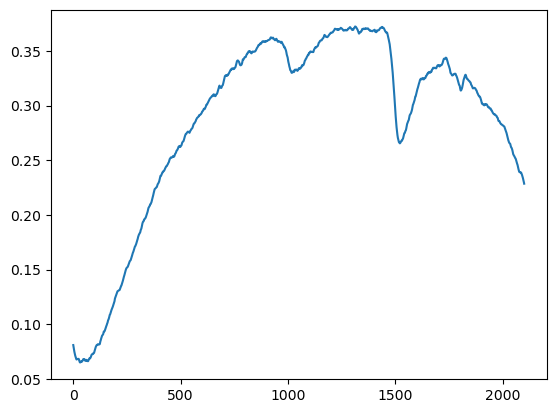

In [15]:
spectratest = savgol_filter(spectratest, 30, 2, axis=1)
plt.plot(spectratest[:, :].T)

# run wet spectra model

In [16]:
# define SMCs (%)
SMCs_show = torch.tensor([2, 6, 10, 14, 18, 22])
SMCs_show_input = SMCs_show.unsqueeze(1).float()
dry_spectra_input = torch.tensor(spectratest).float().repeat(SMCs_show_input.shape[0], 1) # repeat the dry spectrum for the number of SMCs
wet_spectra_show_predict = MW.modelwater(dry_spectra_input,  SMCs_show_input, 'cpu')

In [17]:
# show differences between wet and dry spectra
# dry_spectra = torch.tensor(spectratest).float().repeat(SMCs_show_input.shape[0], 1)
# diff = (dry_spectra - wet_spectra_show_predict.cpu())
# plt.plot(diff.cpu().numpy().T)

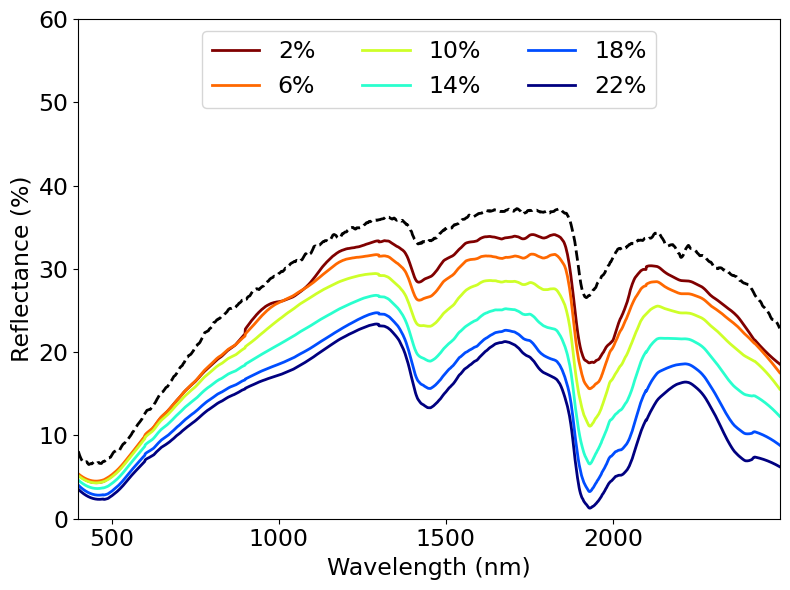

In [18]:
# plot dry and wet spectra
x_limit = (400, 2500)
y_limit = (0, 60)
x_label = 'Wavelength (nm)'
y_label = 'Reflectance (%)'
fontsz = 17

# Colors
colors = cm.jet(np.linspace(0, 1, len(SMCs_show)))  # Colormap

plt.figure(figsize=(8, 6))

# Plot each SMC level with a color from the colormap
for i, smc in enumerate(SMCs_show):
    plt.plot(wavelength, 100 * wet_spectra_show_predict[i].cpu(), color=colors[-1 - i], linewidth=2)

# Plot spectratest data
plt.plot(wavelength, 100 * spectratest.T, 'black', linestyle='--', linewidth=2)

# Plot settings
plt.xlabel(x_label, fontsize=fontsz)
plt.ylabel(y_label, fontsize=fontsz)
plt.legend([f'{smc}%' for smc in SMCs_show], fontsize=fontsz, loc='upper center', ncol=3)
plt.xlim(x_limit)
plt.ylim(y_limit)
plt.xticks([500, 1000, 1500, 2000], fontsize=fontsz)
plt.yticks(fontsize=fontsz)
plt.tight_layout()

# Save the plot as an image file
# plt.savefig('results/spectraSMCs.jpeg', format='jpeg', dpi=300)  # dpi is optional, for resolution adjustment
plt.show()
# plt.close()  # Close the figure

# test spectra padding model

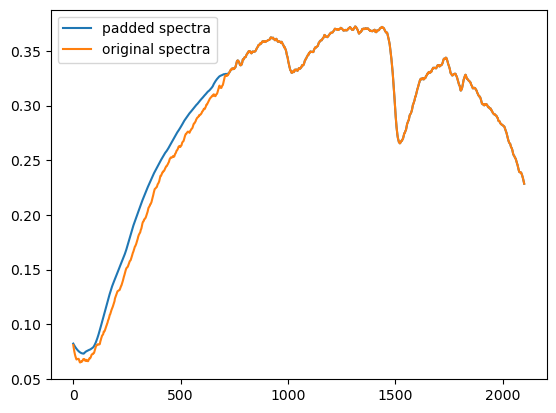

In [20]:
# set part of the test spectra to 0
spectra_test_part = torch.tensor(spectratest).float().repeat(1, 1)
spectra_test_part[:, :700] = 0
spectra_test_fill = PS.padspectra(spectra_test_part,'cpu')
plt.plot(spectra_test_fill[:, :].T)
plt.plot(spectratest[:, :].T)
plt.legend(['padded spectra', 'original spectra'])

In [ ]:
prop_test_all = []
Clay = 33
Silt = 47
SOM = 30
Nitrogen = -1
CEC = 30
OC = 8
tP = -1
pH_w = 6.6
Fe = -1
dens = -1
ec = 55
for i in range(4):
    prop_test_all.append(SGf.setProp('ASD', Clay, Silt, SOM, Nitrogen, CEC, OC, tP, pH_w, Fe, dens,ec))
    SOM = SOM + 2.5
    OC = OC + 0.5
    CEC = CEC + 2
print(len(prop_test_all))

emb_test = SGf.words2indices(prop_test_all, 42, 16, 509)
spectratest_all = np.zeros((4, 2100))
for i in range(5): # average 5 times
    spectratest = gspec.generatespectra(emb_test, torch.device('cpu'), True)
    spectratest_all = spectratest_all + spectratest*0.2
    
plt.plot(spectratest_all[:, :].T)

spectra_ = []
for i in range(spectratest_all.shape[0]):
    spectra_.append((wavelength, spectratest_all[i, :].T, f"Generated soil reflectivity {i}"))
# SGf.saveSpectra2heliosxml(spectra_, "results/soilmapspectra.xml")

In [ ]:
# generate square soil map obj and xml label file
# Parameters for the ground surface
width = 500  # Width of the grid
height = 500  # Height of the grid
scale = 0.5  # Scale for height variations

# Generate a grid of points
vertices = [(x, y, random.uniform(-scale, scale)) for x in range(width) for y in range(height)]

In [ ]:
# Generate a random label map

random_terrain = np.random.rand(width, height)
# Apply Gaussian filter to smooth the terrain
sigma = 50 # Adjust the sigma value to control the smoothness
smooth_terrain = gaussian_filter(random_terrain, sigma=sigma)
smooth_terrain = (smooth_terrain - np.min(smooth_terrain)) / (np.max(smooth_terrain) - np.min(smooth_terrain))
smooth_map_array = np.round(smooth_terrain*3)

# Save the array to a text file

# Plot the map
plt.figure(figsize=(6, 6))
plt.imshow(smooth_map_array, cmap='tab20c')
plt.axis('off')
plt.colorbar(label='Region Label')
# Save the figure before plt.show()
# plt.savefig('results/soilmap.png')  # Make sure the 'results/' directory exists

# Show the plot
plt.show()

In [ ]:
# Generate faces (using triangles or quadrilaterals)
faces = []
labels = []
for x in range(width - 1):
    for y in range(height - 1):
        label = smooth_map_array[x,y]
        # Define vertices for each face (quadrilateral)
        v1 = x * height + y
        v2 = v1 + height
        v3 = v2 + 1
        v4 = v1 + 1
        # Add two triangles for each quadrilateral
        faces.append((v1, v2, v3))
        faces.append((v1, v3, v4))
        labels.append(label)
        labels.append(label)
print(f"Number of vertices: {len(faces)}")
print(f"Number of labels: {len(labels)}")
# Write to an OBJ file
# with open("results/ground_surface_large.obj", "w") as file:
#     for v in vertices:
#         file.write(f"v {v[0]} {v[1]} {v[2]}\n")
#     for f in faces:
#         file.write(f"f {f[0] + 1} {f[1] + 1} {f[2] + 1}\n")

# save labels to xml file
labels_ = []
uuids = np.arange(len(labels))
print(len(uuids))
for i in range(1):
    labels_.append((uuids,labels, f"Soil label {i}"))
# SGf.saveSpectra2heliosxml(labels_, "results/ground_surface_large_labels.xml")

In [ ]:
import os

current_directory = os.getcwd()
print(current_directory)
